In [1]:
import numpy as np
from cosmoTransitions.tunneling1D import SingleFieldInstanton
from cosmoTransitions import generic_potential_Gegenbauer
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import scipy.integrate as integrate
import random
from scipy import interpolate, special
import seaborn as sns
from scipy import misc
from scipy.special import gegenbauer
from scipy.special import eval_gegenbauer
from scipy.special import roots_gegenbauer



%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams["figure.figsize"] = (8, 6)  #set default figure size

label_size=20
thick_size=20


####Some definitions##
v2 = 246.2**2
mh=125.09
v=246.2
alpha=1/137
sinthw=np.sqrt(0.223)
g1=np.sqrt(4*np.pi*alpha/(1-sinthw**2))
g=np.sqrt(4*np.pi*alpha)/sinthw
Mplanck=2.4*10**18
cs=1/3**0.5 ##Sound speed constant


####This code uses an interpoaltion function for the number of degrees of freedom as function of temperature
###Data is obtained from https://member.ipmu.jp/satoshi.shirai/EOS2018
gtab = np.loadtxt( 'standardmodel2018.txt' )[::20]
g_star=interpolate.interp1d(gtab[::,0], gtab[::,1], kind='cubic')
g_sstar=interpolate.interp1d(gtab[::,0], gtab[::,3], kind='cubic')


def Hubble_radiation(T):
    """Hubble rate (squared) coming from radiation dof"""
    num_dof=g_star(T)
    Hubble_rad_squared=num_dof*np.pi**2/90*T**4/Mplanck**2
    return Hubble_rad_squared

def Gamma_Hubble4(S,T):
    """Nucleation probability per Hubble volume, including matter contribution. 
    Integrand in formula (2.2) 1809.08242 """
    Gamma1=T**4*np.exp(-S/T)*np.sqrt((S/2/np.pi/T))**(3)
    return Gamma1


####MY FUNCTIONS START HERE      


def GBpotential(z,**coeffs):
    """Evaluate a linear combination of Gegenbauer polynomials at the point z. 
    coeffs: dictionary containing {Ngb, [(n1,a1),...]} where a is the coefficient in front 
    of the polynomial of order n"""
    Ngb=coeffs["Ngb"]
    lam=(Ngb-1)/2
    x=np.cos(z)
    pot=0
    for n,a in coeffs["na_coeffs"]:
        pot+=a*eval_gegenbauer(n,lam,x)
    return pot

def findGBminima(potential,**args):
    fun=lambda z :potential(z,**args)
    Dfun=lambda z :misc.derivative(fun, x0=z, dx=1e-2, n=1)
    D2fun=lambda z :misc.derivative(fun, x0=z, dx=1e-2, n=2)
    sols=[]
    for i in np.linspace(0,np.pi/2,30):
        #sol=optimize.fmin(Dfun, x0=i,disp=False,ftol=1e-25)
        sol=optimize.root(Dfun, x0=i)
        #sol=optimize.root(Dfun, [i], jac=Dfun, method='hybr')
        if sol.x<0 or D2fun(sol.x)<0 or sol.x>np.pi/2:
            continue
        sols.append(np.round(sol.x,4))
        
    return np.unique(sols)


def kappa(xi_w,alpha):
    """
    Fit for the efficiency factor 
    """
    c_s         = 1./np.sqrt(3.)
    #kappa_A     = xi_w**1.2 * 6.9*alpha/(1.39-0.0037*np.sqrt(alpha)+alpha)
    kappa_A     = xi_w**1.2 * 6.9*alpha/(1.36-0.037*np.sqrt(alpha)+alpha)
    #kappa_B     = alpha**0.4/(0.0017+(0.997+alpha)**0.4)
    kappa_B     = alpha**0.4/(0.017+(0.997+alpha)**0.4)
    #kappa_C     = np.sqrt(alpha)/(0.135+np.sqrt(0.98)+alpha)
    kappa_C     = np.sqrt(alpha)/(0.135+np.sqrt(0.98+alpha))
    #kappa_D     = alpha/(0.75+0.085*np.sqrt(alpha)+alpha)
    kappa_D     = alpha/(0.73 + 0.083*np.sqrt(alpha)+alpha)
    delta_kappa = -0.9*np.log10(np.sqrt(alpha)/(1.+np.sqrt(alpha)))
    xi_w_J      = (np.sqrt(2./3.*alpha+alpha**2)+1./np.sqrt(3.))/(1.+alpha)

    if xi_w < c_s:
    # deflagration
        return c_s**2.2 * kappa_A * kappa_B / ( (c_s**2.2 - xi_w**2.2 )*kappa_B + xi_w * c_s**1.2 * kappa_A )
    elif xi_w < xi_w_J:
    # hybrid
        return (
            kappa_B
            + (xi_w -c_s)*delta_kappa
            + (xi_w-c_s)**3/(xi_w_J-c_s)**3 * ( kappa_C - kappa_B - (xi_w_J-c_s)*delta_kappa )
        )
    else:
        # detonation
        return (xi_w_J-1.)**3 * (xi_w_J/xi_w)**2.5 * kappa_C * kappa_D /(
            ( (xi_w_J-1.)**3 - (xi_w-1.)**3 ) * xi_w_J**2.5 * kappa_C
            + (xi_w-1.)**3 * kappa_D)



LISA_sens = np.loadtxt( 'PLS_ESACallv1-2_04yr.txt' )[::20]
def GW_signal(Temp,alpha,beta,vel):
    HR=(8*np.pi)**(1/3)*max(vel,cs)/beta ##eqn. (7.5)
    f_sw=2.6*1e-5/HR*(Temp/100)*(g_star(Temp)/100)**(1/6) ##eqn. (7.3)
    Sw = lambda f: (f/f_sw)**3*(4/7 + 3/7*(f/f_sw)**2)**(-7/2) ##eqn. (7.2)
    Uf=np.sqrt(3/4*alpha/(1+alpha)*kappa(vel,alpha))##eqn. (7.4)
    tauH = HR/Uf ##eqn. (7.4)
    prefactor=4.13*1e-7*HR*(1-1/np.sqrt(1+2*tauH))*(kappa(vel,alpha)*alpha/(1+alpha))**2 ##eqn. (7.1)
    Omega=lambda f: prefactor*(100/g_star(Temp))**(1/3)*Sw(f) ##eqn. (7.1)
    #f_range=LISA_sens[::,0]
    f_range=np.logspace(-10,4,500)
    GW_tab=[Omega(f) for f in f_range]
    return np.array([list(f_range), list(GW_tab)])


def SNR_GW(signal):
    """Computes SNR given signal (f,Omega)"""
    time=4
    f,Om=signal
    OmGW=interpolate.interp1d(f,Om, kind='cubic')
    Om=OmGW(LISA_sens[::,0])
    On=LISA_sens[::,3]
    integral=integrate.simps(Om**2/On**2,LISA_sens[::,0])
    SNR_val=(time*3.15*10**7*integral)**0.5

    return SNR_val



Now we consider the next-to-minimal case by adding an extra Gegenbauer polynomial which is a small correction to our benchmark case of the preceding section. The motivation to do so is the following: suppose the pseudo-Goldstone potential is a linear combination of two Gegenbauer polynomials and only one of them dominates at zero temperature, then at high temperatures the potential acquires the form

$$V_T \approx \frac{T^2}{24 f^2} \left[ -a_1 n_1(n_1+2\lambda)G^{\lambda}_{n_1} -  a_2 n_2(n_2+2\lambda)G^{\lambda}_{n_2} \right] $$

Since there is a hierarchy $a_1 \gg |a_2|$ ($a_1$ is assumed to be positive while $a_2$ can be of either sign), the second Gegenbauer can  overtake the first one provided the order of the polynomial satisfies

$$n_2(n_2+\lambda) > \frac{a_1}{|a_2|}n_1(n_1+2\lambda) $$

which translates into a lower bound 
$$n_2 > n_2^{min}\equiv \lceil -\frac{\lambda}{2} + \sqrt{\frac{\lambda^2}{4} + \frac{n_1(n_1+2\lambda)a_1}{|a_2|}} \rceil $$

Minimum value of next Gegenbauer is n2= 20.710719932006008
Which ceils to n2= 21
False True 1.0956521739130434


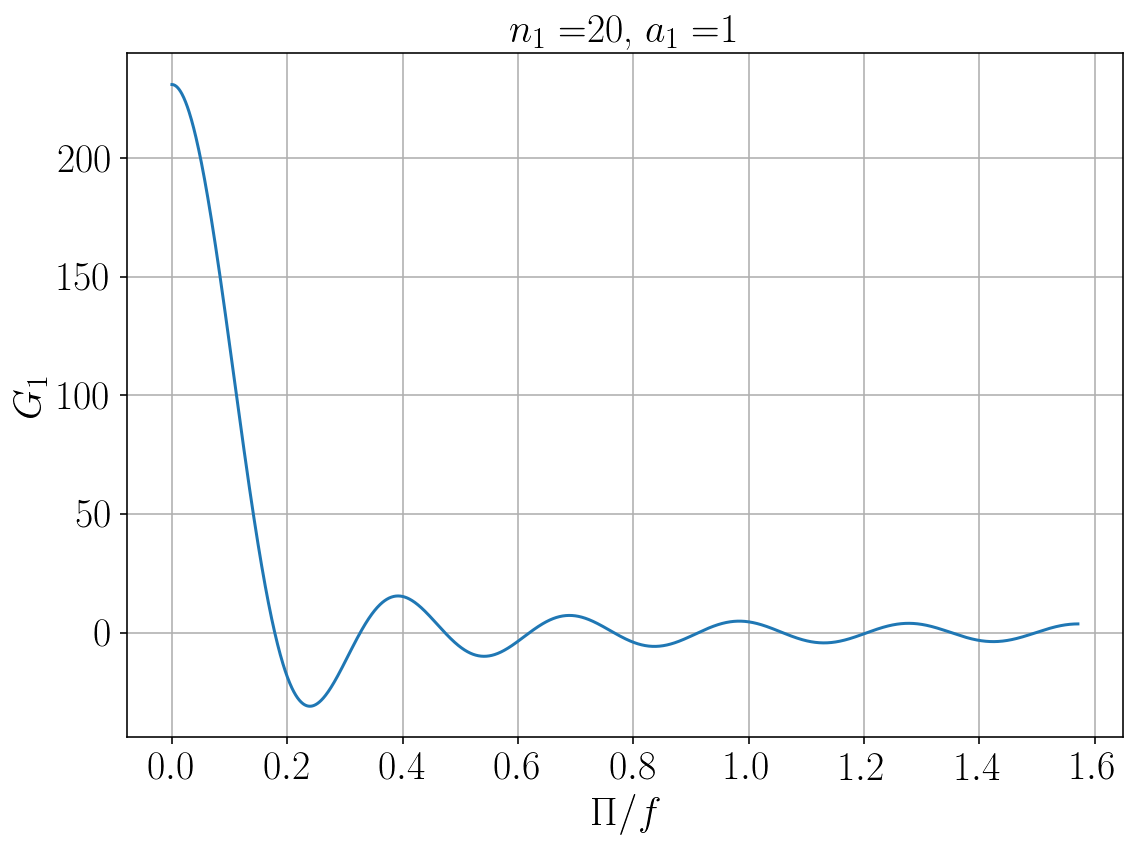

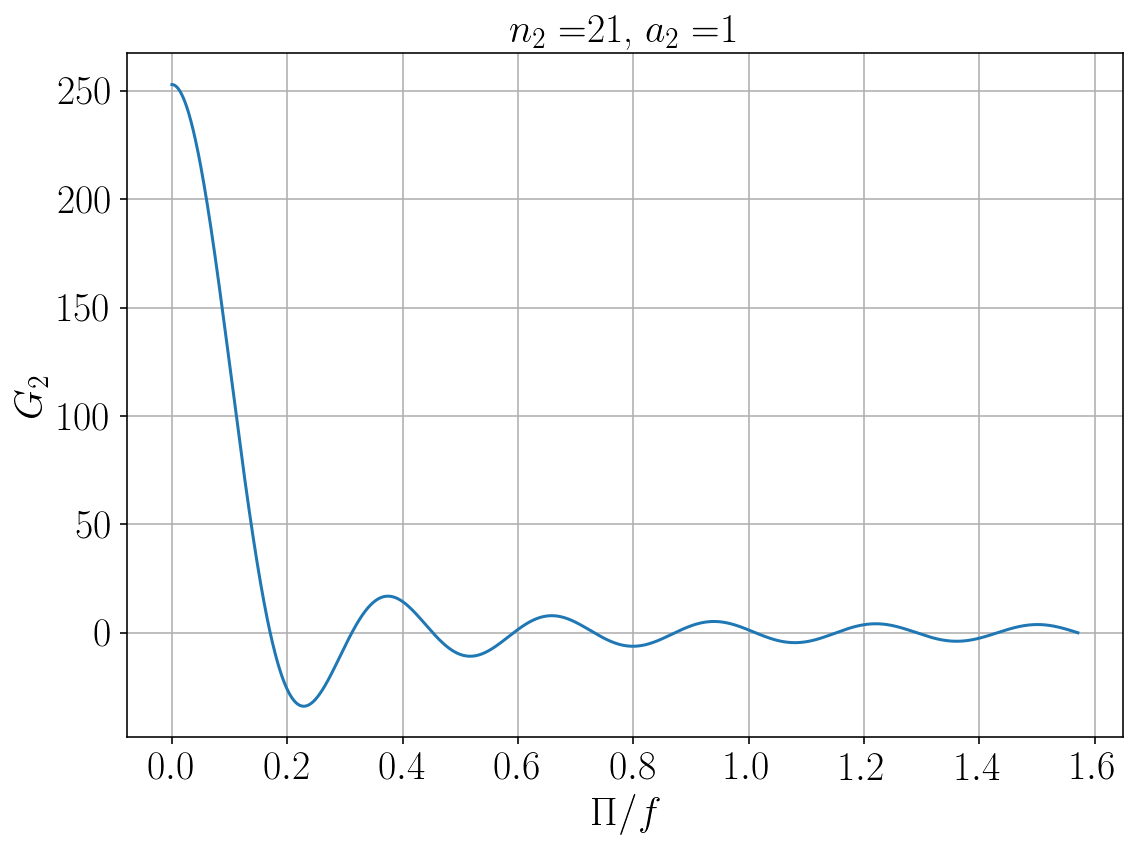

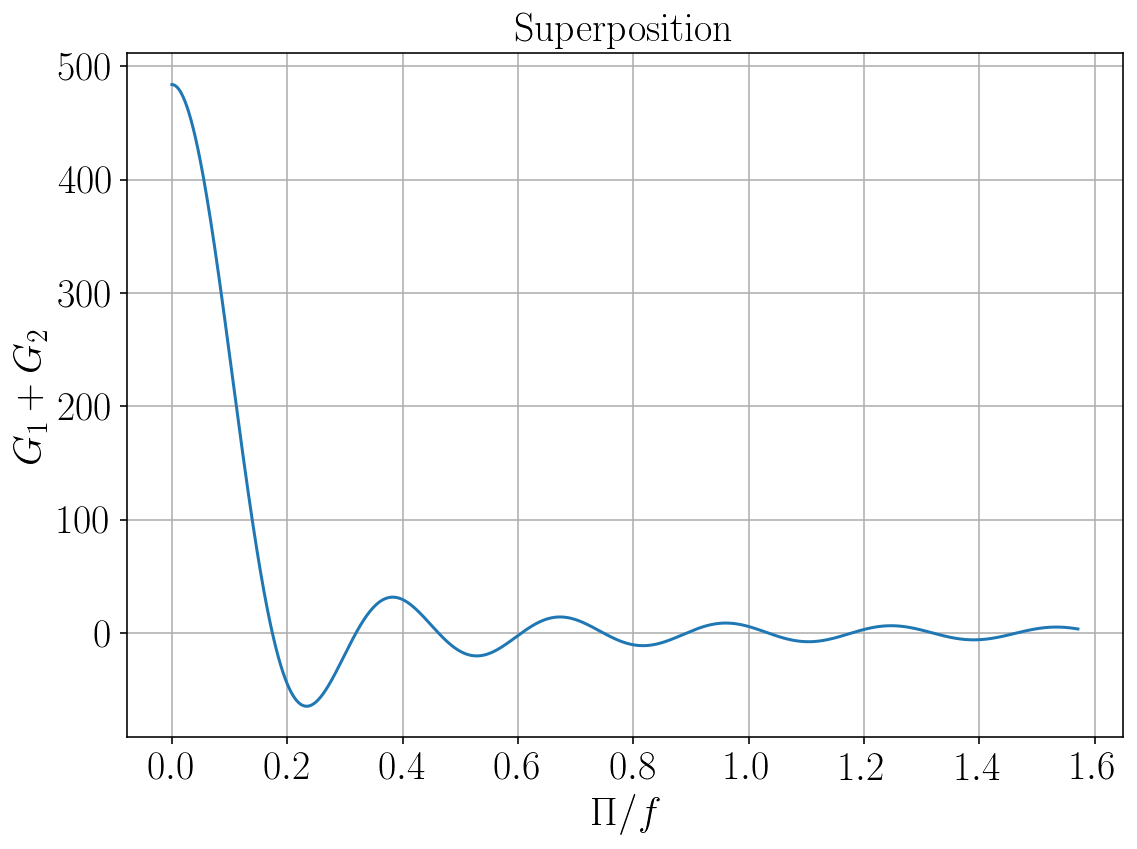

In [2]:
lam=1.5

n1, a1 =20, 1
a2 =1

n2_least=-lam/2 + np.sqrt(lam**2/4 + n1*(n1+2*lam)*abs(a1/a2))
print("Minimum value of next Gegenbauer is n2=",n2_least)
n2=np.int(np.ceil(n2_least))
#if n2%2==1:
#    n2+=1
n2+=0
print("Which ceils to n2=",n2)
print(a2<a1 , n2*(n2+2*lam)>abs(a1/a2)*n1*(n1+2*lam) , n2*(n2+2*lam)/(abs(a1/a2)*n1*(n1+2*lam)))

myargs={"Ngb":4,"na_coeffs":[(n1, a1)]}
z_range=np.linspace(0,np.pi/2,2000)
#min_list=findGBminima(GBpotential,**myargs)
plt.plot(z_range,GBpotential(z_range,**myargs))
#plt.scatter(min_list,GBpotential(min_list,**myargs),c="r")
plt.xlabel("$\Pi/f$",size=label_size)
plt.ylabel("$G_1$",size=label_size)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.grid(True)
plt.title("$n_1=$"+str(n1)+", $a_1=$"+str(a1),size=label_size)
plt.tight_layout()
plt.savefig('./PLOTS/G_hierachical_1.pdf', dpi=300)
plt.show()


myargs={"Ngb":4,"na_coeffs":[(n2, a2)]}
z_range=np.linspace(0,np.pi/2,2000)
#min_list=findGBminima(GBpotential,**myargs)
plt.plot(z_range,GBpotential(z_range,**myargs))
#plt.scatter(min_list,GBpotential(min_list,**myargs),c="r")
plt.xlabel("$\Pi/f$",size=label_size)
plt.ylabel("$G_2$",size=label_size)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.grid(True)
plt.title("$n_2=$"+str(n2)+", $a_2=$"+str(a2),size=label_size)
plt.tight_layout()
#plt.savefig('./PLOTS/G_hierachical_2.pdf', dpi=300)
plt.show()

myargs={"Ngb":4,"na_coeffs":[(n1, a1),(n2, a2)]}
z_range=np.linspace(0,np.pi/2,2000)
#min_list=findGBminima(GBpotential,**myargs)
plt.plot(z_range,GBpotential(z_range,**myargs))
#plt.scatter(min_list,GBpotential(min_list,**myargs),c="r")
plt.xlabel("$\Pi/f$",size=label_size)
plt.ylabel("$G_1+G_2$",size=label_size)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.grid(True)
plt.title("Superposition",size=label_size)
plt.tight_layout()
#plt.savefig('./PLOTS/G_hierachical_3.pdf', dpi=300)
plt.show()

In [3]:
class model1(generic_potential_Gegenbauer.generic_potential):

    def init(self, adict):
        self.Ndim = 1
        self.Ngb=adict["Ngb"]
        self.adict=adict
        
        min_list=findGBminima(GBpotential,**adict)
        V_min=min(GBpotential(min_list,**adict))
        global_min=list(GBpotential(min_list,**adict)).index(V_min)
        
        self.vacua_list=min_list
        self.f=v/min_list[global_min]
        self.renormScaleSq = self.f**2
        
        ##Determine normalization constant
        fun=lambda h : GBpotential(h/self.f,**adict)
        DG=misc.derivative(fun, x0=v, dx=1e-2, n=1,order=5)
        D2G=misc.derivative(fun, x0=v, dx=1e-2, n=2,order=5)
        self.const=mh**2/(D2G) ##Formula 2.2 of on draft
        #print(self.const/self.f**4)
        
        #z_range=np.linspace(0,self.f*np.pi/2,1000)
        #self.pot_fun=interpolate.interp1d(z_range,GBpotential(z_range,**adict))
        
        self.Trestored=None
        self.phases=None
        self.Tc=None
        self.df_nuc=None
 
    def forbidPhaseCrit(self, X):
        return any([np.array([X])[...,0] < -5.0])

    def V0(self, X):
        X = np.asanyarray(X)
        h = X[...]
        z=h/self.f
        #pot = self.const*self.pot_fun(z)
        pot =self.const*GBpotential(z,**self.adict)
        
        return pot
    
    def Higgs_trilinear(self):
        """This method compute the Higgs trilinear with respect to the SM value"""
        chhhSM = 3*mh**2/v
        DG3=misc.derivative(self.V0, x0=v, dx=1e-1, n=3,order=7)
        #self.Higgs_trilinear=DG3/chhhSM
        return DG3/chhhSM

    
    def plot1(self):
        z_range=np.linspace(0,self.f*np.pi/2,300)

        plt.plot(z_range,self.V0(z_range),label="Tree-level")
        plt.scatter(self.vacua_list*self.f,self.V0(self.f*self.vacua_list))
        plt.xlabel("$\Pi$ [GeV]",size=label_size)
        plt.ylabel("$G$",size=label_size)
        plt.legend(prop={'size': label_size})
        plt.xticks(fontsize=thick_size)
        plt.yticks(fontsize=thick_size)
        plt.grid(True)
        plt.tight_layout()
        #plt.savefig('./LISA_SCANS_1/CLUSTER/PLOTS/lagrangian_params_marginalized.pdf', dpi=300)
        #plt.show()
        
    def plot2(self,T):
        z_range=np.linspace(1e-7,self.f*np.pi/2,200)

        plt.plot(z_range,self.Vtot(z_range,T),"g--",label="1-loop potential")
        #plt.scatter(self.vacua_list*self.f,self.Vtot(self.f*self.vacua_list,0))
        
        plt.legend()
        plt.legend(prop={'size': label_size})
        plt.xlabel("$\Pi$ [GeV]",size=label_size)
        plt.ylabel("$G$",size=label_size)
        plt.xticks(fontsize=thick_size)
        plt.yticks(fontsize=thick_size)
        plt.grid(True)
        mytitle="Effective potential at T= "+str(np.round(T,1))+" GeV"
        plt.title(mytitle,size=label_size)
        plt.tight_layout()
        #plt.savefig('./LISA_SCANS_1/CLUSTER/PLOTS/lagrangian_params_marginalized.pdf', dpi=300)
        #plt.show()
        
    
    def boson_massSq(self, X, T):
        X = np.asanyarray(X)
        h = X[...,]
        
        ##Determine normalization constant
        fun=lambda x :self.V0(x)
        DG=misc.derivative(fun, x0=h,  n=1)
        D2G=misc.derivative(fun, x0=h, n=2)
       
        Mh2=D2G
        MG2=DG/np.tan(h/self.f)/self.f

        M = np.array([Mh2,MG2])
        M = np.rollaxis(M, 0, len(M.shape))

        dof = np.array([1,self.Ngb-1])

        c = np.array([.5,.5])

        return M, dof, c
    def fermion_massSq(self, X):
        X = np.asanyarray(X)
        h = X[...,]

        mt=1**2*h**2/2
        M = np.array([mt])

        M = np.rollaxis(M, 0, len(M.shape))

        dof = 0*np.array([12])
        return M, dof
    
    def approxZeroTMin(self):
        return [np.array(v),]
    
    def isEWSB(self):
        print("The global minimum is")
        Vval=np.inf
        xglobal=0
        for vac in self.vacua_list*self.f:
            x0=self.findMinimum(vac,0)
            if self.Vtot(x0,0)<Vval:
                Vval=self.Vtot(x0,0)
                xglobal=x0
                continue
            else:
                continue
        print(Vval,xglobal )
    def findTrestoration(self):
        """Find temperature of symmetry restoration"""
        Tmax,Tmin=self.f,100
        def fun_optimize(n):
            index=0
            T_range=np.linspace(Tmax,Tmin,n)
            for Temp in T_range:
                hmin=np.unique([abs(float(np.round(self.findMinimum(h0,Temp),1))) for h0 in np.linspace(1,self.f,15)])
                V_list=[self.Vtot(abs(h0)+1e-5,Temp) for h0 in hmin]
                min_index=V_list.index(min(V_list))
                if hmin[min_index]>20:
                    return T_range[index-1],T_range[index] 
                index+=1
        for n in range(100):
            Tmax, Tmin=fun_optimize(10)
            #print(Tmax,Tmin)
            if abs(Tmax-Tmin)<5:
                self.Trestored=Tmax
                break
            elif Tmin>Tmax:
                print("Symmetry not restored")
                Tmax=Tmin
                break
        return  Tmax
        
    def findTrestoration_old2(self):
        """Find temperature of symmetry restoration"""
        Tmax,Tmin=self.f,100
        def fun_optimize(n):
            T_range=np.linspace(Tmax,Tmin,n)
            index=0
            for Temp in T_range:
                index+=1
                h0=self.findMinimum(10,Temp)
                h1=self.findMinimum(300,Temp)
                h2=self.findMinimum(self.f/2,Temp)
                condition1=abs(h0)<50 and abs(abs(h0)-abs(h1))>10 and self.Vtot(abs(h0),Temp)<self.Vtot(abs(h1),Temp)
                condition2=abs(h0)<50 and abs(abs(h0)-abs(h2))>10 and self.Vtot(abs(h0),Temp)<self.Vtot(abs(h2),Temp)
                if condition1==False or condition2==False:
                    return T_range[index-2],Temp
        for n in range(100):
            Tmax, Tmin=fun_optimize(10)
            if Tmax-Tmin<5:
                print(Tmax,Tmin)
                self.Trestored=Tmax
                break
        return  Tmax

        
    def findTrestoration_old(self,n):
        """Find temperature of symmetry restoration"""
        T_range=np.linspace(self.f,100,n)
        for Temp in T_range:
            h0=self.findMinimum(10,Temp)
            h1=self.findMinimum(300,Temp)
            h2=self.findMinimum(self.f/2,Temp)
            condition1=abs(h0)<10 and abs(abs(h0)-abs(h1))>10 and self.Vtot(abs(h0),Temp)<self.Vtot(abs(h1),Temp)
            condition2=abs(h0)<10 and abs(abs(h0)-abs(h2))>10 and self.Vtot(abs(h0),Temp)<self.Vtot(abs(h2),Temp)
            if condition1==False or condition2==False:
                self.Trestored=Temp
                return Temp
            
    def findTrestoration_old1(self):
        """Find temperature of symmetry restoration"""
        h0=self.findMinimum(1,self.f)
        if abs(h0)>10:
            print("Symmetry is not restored")
        def fun_optimized(Temp):
            hmin=[self.findMinimum(h0,Temp) for h0 in np.linspace(1,self.f,20)]
            Vmin=[np.round(float(self.Vtot(h0,Temp)),5) for h0 in hmin]
            min_index=Vmin.index(min(Vmin))
            return abs(hmin[min_index])**2 + abs(Vmin[min_index])/Temp**4
        output=optimize.minimize_scalar(fun_optimized,bounds=(100,self.f))
        output=float(output.x)
        if output<0 or output>self.f:
            print("findTrestoration failed")
            self.Trestored=self.f
        else:
            self.Trestored=output
        return self.Trestored

    
    def minTracker(self):
        """Method to track the phases. It stores the output in a dictionary and saves it into
        self.phases"""
        if self.Trestored==None:
            self.findTrestoration()
        phases_dict={}
        T_range=np.arange(0,self.Trestored,.1)[::-1]
        for Temp in T_range:
            hmin=np.unique([abs(float(np.round(self.findMinimum(h0,Temp),1))) for h0 in np.linspace(1,self.f,15)])
            if Temp==self.Trestored:
                for i in range(len(hmin)):
                    phases_dict.update({"phase_"+str(i):{"phi":[hmin[i]],"T":[Temp]}})
            else:
                for i in range(len(hmin)):
                    #Compare with minima obtained at the last Temperature
                    last_phis=[float(abs(phases_dict[phase]["phi"][-1]-hmin[i])) for phase in list(phases_dict.keys())]
                    belongsto_index=np.where(np.array(last_phis)<5)[0]
                    #if it doesn't belong to any phase, create a new phase
                    if len(belongsto_index)==0:
                        newindex=len(phases_dict.keys())
                        phases_dict.update({"phase_"+str(newindex):{"phi":[hmin[i]],"T":[Temp]}})
                    else:
                        phase=list(phases_dict.keys())[belongsto_index[0]]
                        phases_dict[phase]["phi"].append(hmin[i])
                        phases_dict[phase]["T"].append(Temp)
        
        self.phases=phases_dict
        for phase in list(phases_dict.keys()):
            if len(phases_dict[phase]["phi"])<10:
                phases_dict.pop(phase)
                continue
            phases_dict[phase]["phi"]=np.array(phases_dict[phase]["phi"])
            phases_dict[phase]["T"]=np.array(phases_dict[phase]["T"])
            phase_interpolated=interpolate.interp1d(phases_dict[phase]["T"], phases_dict[phase]["phi"])
            phases_dict[phase]["interp"]=phase_interpolated
            
        self.phases=phases_dict
        return phases_dict     
    def plot3(self,phases_list):
        """Plot phases as a function of temperature
        input phases_list: a list of string with the name of the phase
        """
        if self.phases==None:
            phase_output=self.minTracker()
        plt.rc("text", usetex=False)
        for phase in phases_list:
            if len(self.phases[phase]["phi"])<10:
                plt.scatter(self.phases[phase]["T"],self.phases[phase]["phi"],label=phase)
            else:
                plt.plot(self.phases[phase]["T"],self.phases[phase]["interp"](self.phases[phase]["T"]),label=phase)
            plt.legend(loc='upper right', prop={'size': label_size})
        plt.xlabel("$T$ [GeV]",size=label_size)
        plt.ylabel("$\\phi$",size=label_size)
        plt.xticks(fontsize=thick_size)
        plt.yticks(fontsize=thick_size)
        plt.grid(True)
        mytitle="phase history"
        plt.title(mytitle,size=label_size)
        plt.tight_layout()
        
    def findTc_phase(self,i):
        """Find Tc for phase i"""
        def V_global(T):
            """Return the potential at the global minima"""
            allphases=list(self.phases.keys())
            V_list=[]
            for i in range(len(self.phases)):
                try:
                    V_list.append(self.Vtot(self.phases[allphases[i]]["interp"](T)+1e-5,T))
                except:
                    continue
            return min(V_list)
        dict_out=[]
        phase_high="phase_"+str(i)
        if phase_high not in list(self.phases.keys()):
            return []
        dhh=self.phases[phase_high]["phi"].min()
        #for j in range(len(self.phases)):
        #phase="phase_"+str(j)
        for phase in list(self.phases.keys()):   
            dh=self.phases[phase]["phi"].min()
            if dhh<dh:
                Tmax=min(self.phases[phase]["T"].max(),self.phases[phase_high]["T"].max())
                Tmin=max(self.phases[phase]["T"].min(),self.phases[phase_high]["T"].min())
                if Tmin>Tmax:
                    continue
                T_range=np.linspace(Tmin,Tmax)
                DVfun=lambda T: (self.Vtot(self.phases[phase_high]["interp"](T)+1e-5,T)-self.Vtot(self.phases[phase]["interp"](T)+1e-5,T))
                try:
                    #Tcritical=optimize.minimize_scalar(DVfun,bounds=(Tmin,Tmax),method="bounded",options={"disp":False})
                    Tc=optimize.root_scalar(DVfun,bracket=(Tmin,Tmax),method="bisect")
                    if V_global(Tc.root)<self.Vtot(self.phases[phase_high]["interp"](Tc.root)+1e-5,Tc.root) and ( V_global(Tc.root)-self.Vtot(self.phases[phase_high]["interp"](Tc.root)+1e-5,Tc.root))**2>1e-2:
                        continue
                    print("Tunnel possible from",phase_high," to",phase)
                    #self.Tc=Tcritical.x
                    print("\n Critical temperature found, Tc=",Tc.root,"\n")
                    dict_out.append({"high_phase":phase_high,"low_phase":phase,"Tc":Tc.root,"Tmax":Tmax,"Tmin":Tmin})
                except:
                    continue
            else:
                continue
        return dict_out
    
    def findTcritical(self):
        """Find the critial temperature once the phase history is known"""
        if self.phases==None:
            phase_output=self.minTracker()
        else:
            phase_output=self.phases
        allTcTrans=[]
        #maxphase=int((list(self.phases.keys())[-1])[-2:])##Number of last added phase
        maxphase=int((list(self.phases.keys())[-1]).split("_")[-1])
        for i in range(maxphase):
            out=self.findTc_phase(i)
            if len(out)!=0:
                allTcTrans.append(out)
        self.Tc=allTcTrans
    
        
    def nucleation(self,phase_high,phase_low,Temp):
        """compute the instanton and return a dictionary with several thermodynamic variables
        input: phase_high (phase_low): phase objects"""

        phi_false=phase_high["interp"](Temp)
        phi_true=phase_low["interp"](Temp)
        pot_fun=lambda h : self.Vtot(h,Temp)
        
        if phi_false>phi_true or (phi_true-phi_false)<10 or pot_fun(phi_true)>pot_fun(phi_false):
            print("stable not metastable")
            return 
        VT_false=lambda T : self.Vtot(phi_false,T)
        DVT_false=misc.derivative(VT_false, x0=Temp, dx=1e-1, n=1)
        VT_true=lambda T : self.Vtot(phi_true,T)
        DVT_true=misc.derivative(VT_true, x0=Temp, dx=1e-1, n=1)
        rho_r= g_star(Temp)*np.pi**2/30*Temp**4
        alpha_strength=(self.Vtot(phi_false,Temp)-self.Vtot(phi_true,Temp)-Temp/4*(DVT_false-DVT_true))/rho_r
        vwall=np.sqrt((self.Vtot(phi_false,Temp)-self.Vtot(phi_true,Temp))/alpha_strength/rho_r)
        vJ=1/3**.5*(1+np.sqrt(3*alpha_strength**2+2*alpha_strength))/(1+alpha_strength)
        if vwall>=vJ:
            vwall=1

        instanton=SingleFieldInstanton(phi_true, phi_false, pot_fun)
        phi_profile=instanton.findProfile()
        S_3=instanton.findAction(phi_profile)
        Hubble1=Hubble_radiation(Temp)
        Hubble2=((self.Vtot(phi_false,Temp)-self.Vtot(phi_true,Temp))/3/Mplanck**2)
        Hubble=Hubble1+Hubble2
        Gamma_rate=Gamma_Hubble4(S_3,Temp)
        nuc_output={"phi_false":phi_false,"phi_true":phi_true,"Tn":Temp,"Gamma":Gamma_rate,"S_3":S_3,
                    "Hubble1":Hubble1,"Hubble2":Hubble2,
                    "alpha":alpha_strength,"vw":vwall,"vJ":vJ}
        return nuc_output 
    
    
    
    def findSNR(self,index_trans):
        phase_high=self.phases[self.Tc[index_trans][-1]["high_phase"]]
        phase_low=self.phases[self.Tc[index_trans][-1]["low_phase"]]

        Tmin=self.Tc[index_trans][-1]["Tmin"]
        nucleation_list=[]
        for temp in np.linspace(Tmin,self.Tc[index_trans][-1]["Tc"]):
            try:
                nuc_output=self.nucleation(phase_high,phase_low,temp)
                if len(nuc_output)!=0:
                    nucleation_list.append(nuc_output)
            except:
                continue
            
        df_nuc=pd.DataFrame(nucleation_list).dropna()
        
        try:
            N_nuc=interpolate.interp1d(df_nuc["Tn"],df_nuc["Gamma"]/(df_nuc["Hubble1"]+df_nuc["Hubble2"])**2-1)
            Tnuc=optimize.root_scalar(N_nuc,bracket=(df_nuc["Tn"].min(),df_nuc["Tn"].max())).root

            S_T_inter=interpolate.interp1d(df_nuc["Tn"],df_nuc["S_3"]/df_nuc["Tn"])
            beta=Tnuc*misc.derivative(S_T_inter, x0=Tnuc, dx=1e-2, n=1)

            alpha_inter=interpolate.interp1d(df_nuc["Tn"],df_nuc["alpha"])
            vel_inter=interpolate.interp1d(df_nuc["Tn"],df_nuc["vw"])
            vJ_inter=interpolate.interp1d(df_nuc["Tn"],df_nuc["vJ"])

            Temp,al,beta,vel=Tnuc,alpha_inter(Tnuc),beta,vel_inter(Tnuc)
            my_signal=GW_signal(Temp,al,beta,vel)
            SNR_signal=SNR_GW(my_signal)
            dict_out={"Tc_"+str(index_trans):self.Tc[index_trans][-1]["Tc"],
                      "phi_false_"+str(index_trans):phase_high["interp"](Tnuc),
                      "phi_true_"+str(index_trans):phase_low["interp"](Tnuc),
                      "Tn_"+str(index_trans):Tnuc,"alpha_"+str(index_trans):al,
                      "beta_"+str(index_trans):beta,"vw_"+str(index_trans):vel_inter(Tnuc),
                      "vJ_"+str(index_trans):vJ_inter(Tnuc),"SNR_"+str(index_trans):SNR_signal}
        except:
            dict_out={}
        return dict_out




    
  

True vacuum are h= [ 205.2178943   246.2         350.90928007  528.46425302  762.88189763
  801.20016646  940.23196005 1039.8184769  1223.72567624 1317.77960882
 1507.42430295 1596.25301706]
Confinement scale f= 1024.5526425301705


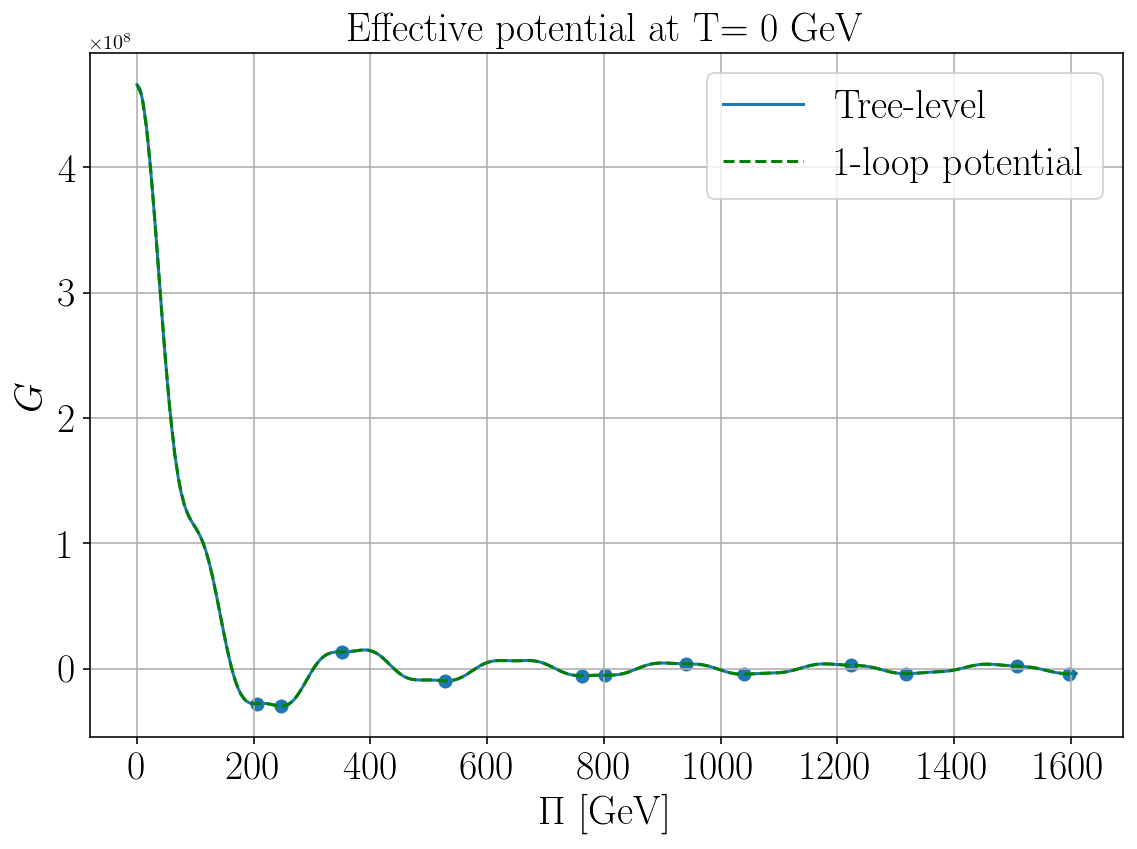

In [9]:
#BM1={'Ngb': 4, 'na_coeffs': [(21, 1), (66, 0.1)]}
#BM2={'Ngb': 4, 'na_coeffs': [(20, 1), (65, 0.1)]}
BM3={'Ngb': 4, 'na_coeffs': [(22, 1), (67,0.1)]} ##Two PTs
#myargs={'Ngb': 4, 'na_coeffs': [(7, 30), (10, -.0001),(55,10)]} ##Very interesting!!!
#myargs={'Ngb': 4, 'na_coeffs': [(7, 30), (10, -.0001),(55,10),(100,-.1)]}
#myargs={'Ngb': 4, 'na_coeffs': [(7, -50), (10, -10),(55,4.2),(100,-.1)]}
#myargs={"Ngb":4,"na_coeffs":[(n1, a1),(n2, a2)]}
myargs=BM3

#myargs={'Ngb': 4, 'na_coeffs': [(np.random.randint(1,100), np.random.randint(-100,100)), (np.random.randint(1,100), np.random.randint(-100,100))]}
m=model1(myargs)
m.include_CW=False

print("True vacuum are h=",m.vacua_list*m.f)
print("Confinement scale f=",m.f)

m.plot1()
m.plot2(0)
#plt.xlim(0,1000)

In [10]:
m.adict

{'Ngb': 4, 'na_coeffs': [(22, 1), (67, 0.1)]}

In [11]:
m.vacua_list*m.f

array([ 205.2178943 ,  246.2       ,  350.90928007,  528.46425302,
        762.88189763,  801.20016646,  940.23196005, 1039.8184769 ,
       1223.72567624, 1317.77960882, 1507.42430295, 1596.25301706])

In [12]:
m.Higgs_trilinear()

6.246339682759356

In [13]:
m.isEWSB()

The global minimum is
[-29823936.19274737] [247.44134751]


In [14]:
%%time
m.findTrestoration()

CPU times: user 4.72 s, sys: 25.2 ms, total: 4.75 s
Wall time: 4.74 s


252.1897353959129

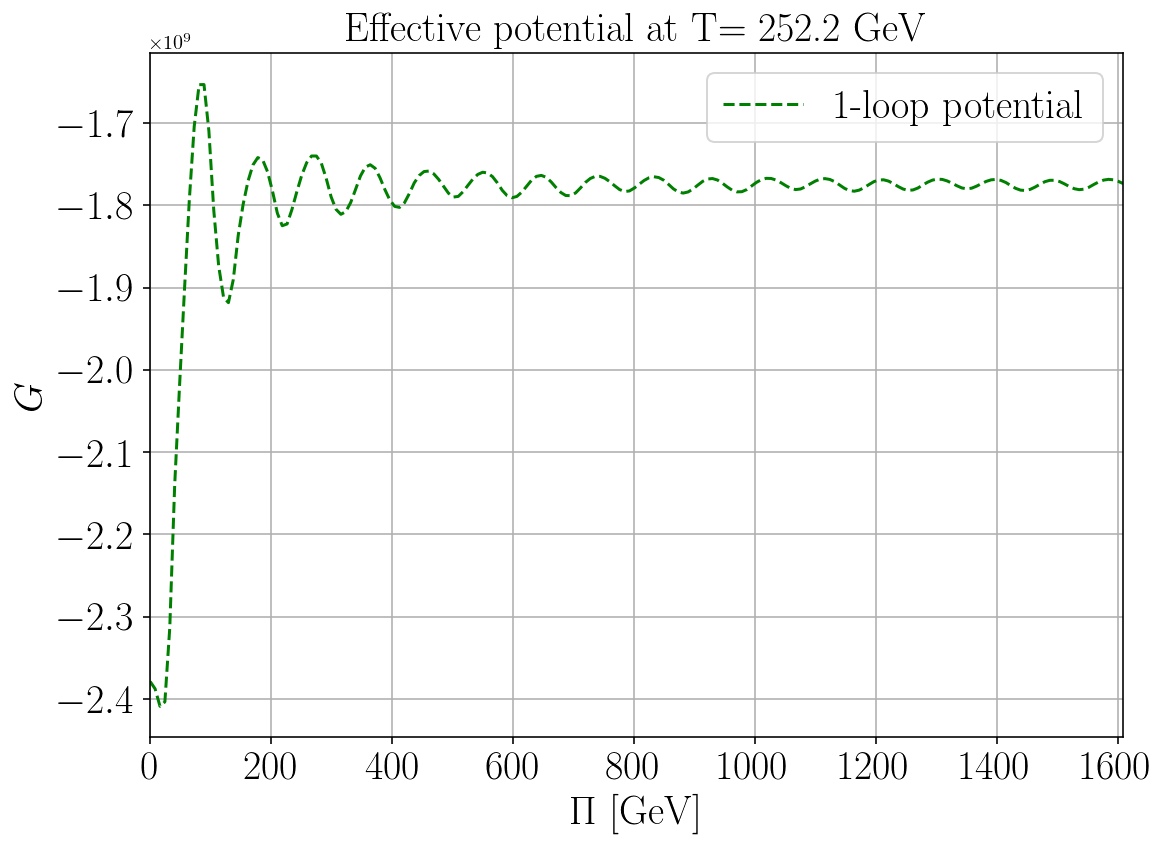

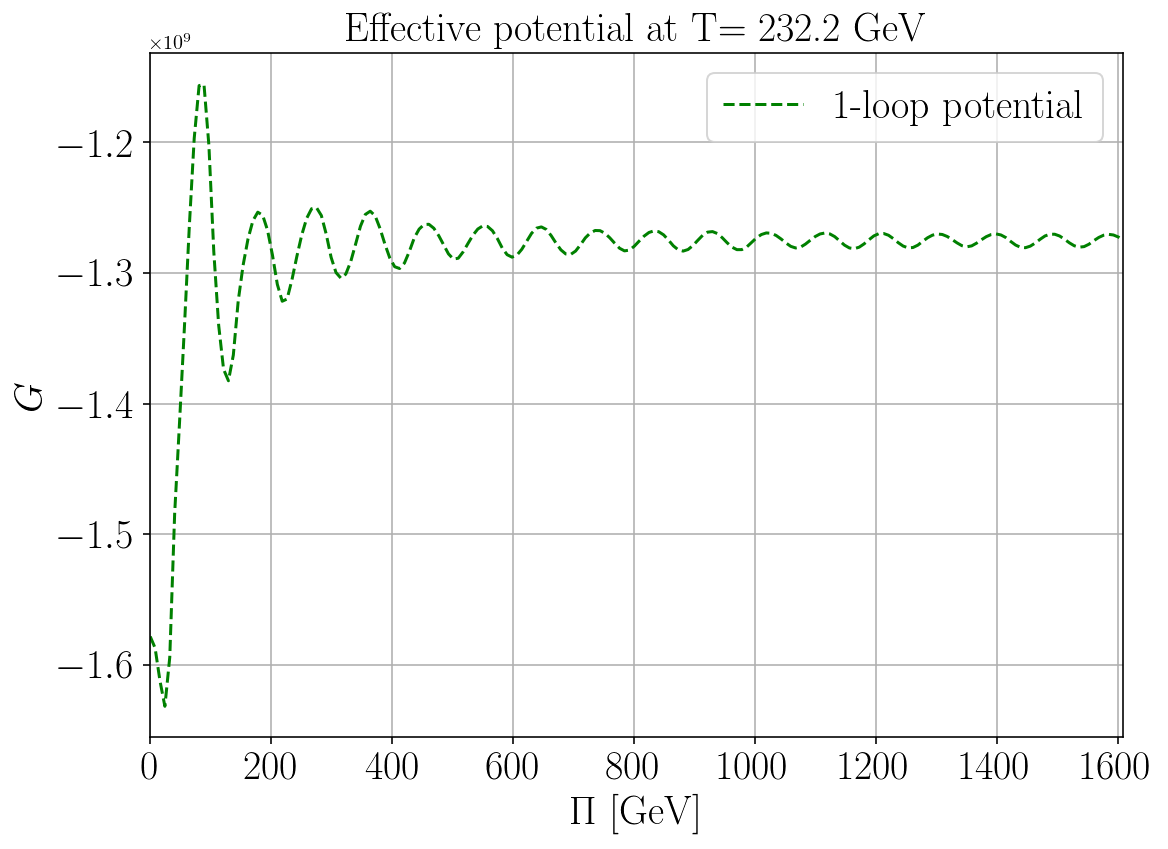

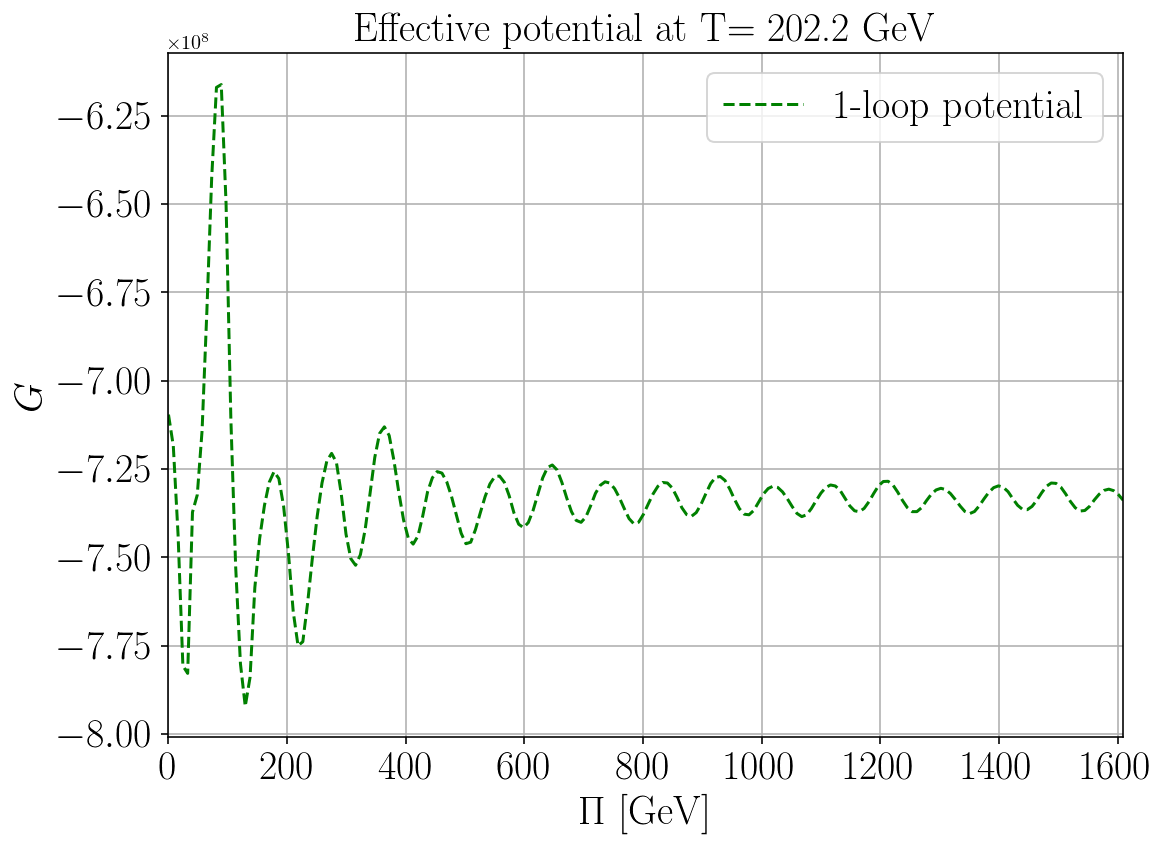

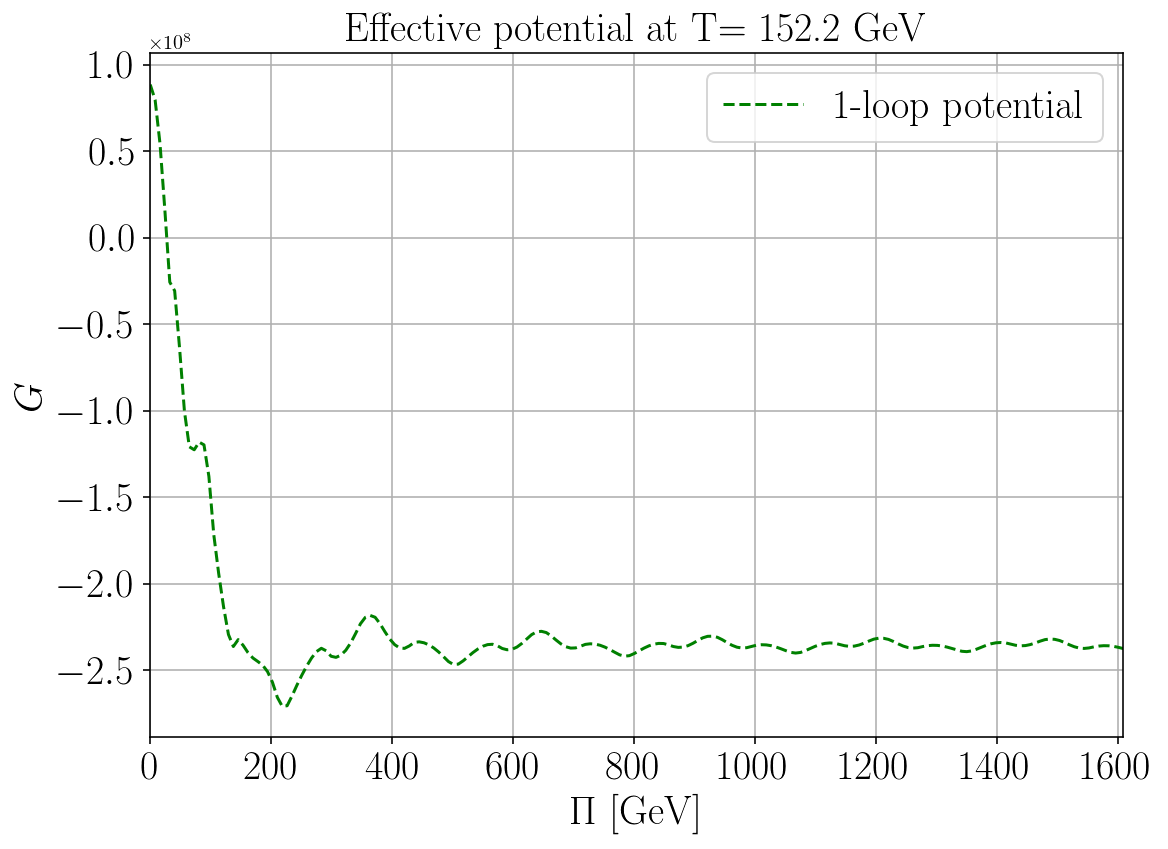

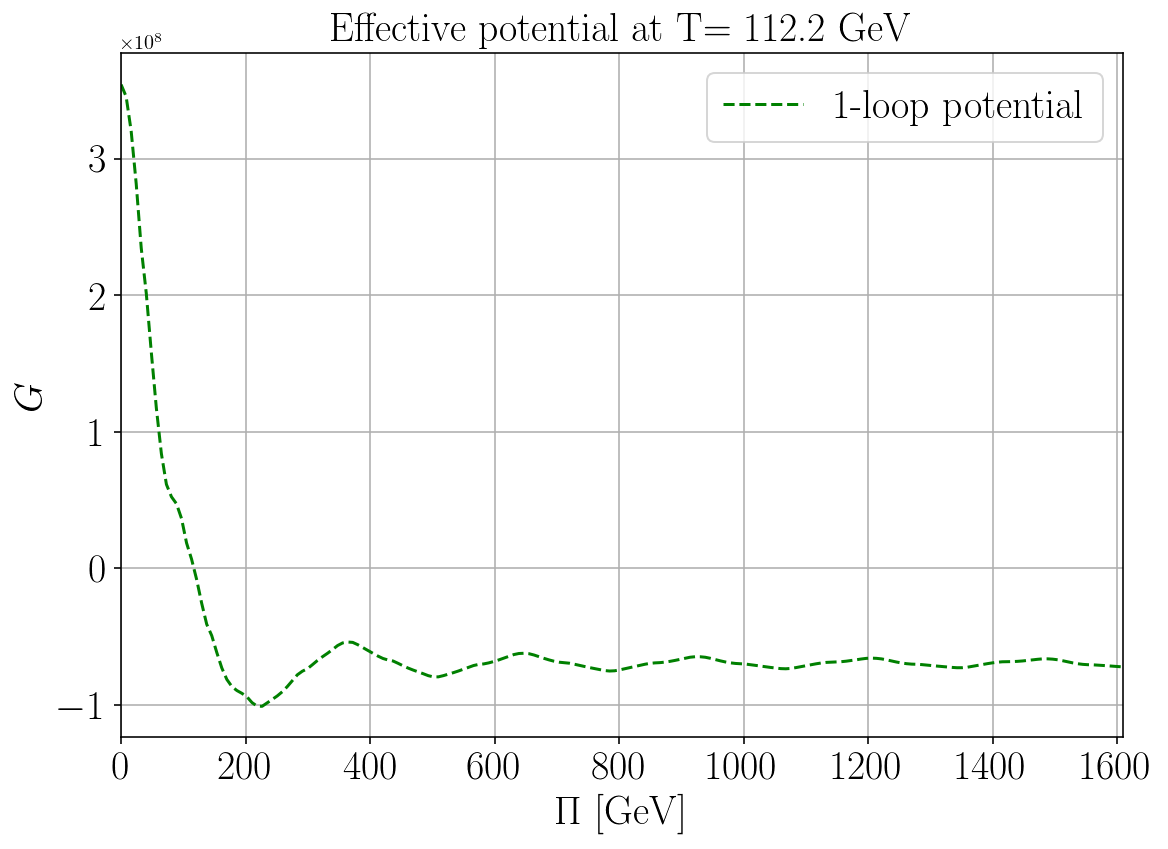

In [15]:
Temp=m.Trestored
m.plot2(Temp)
plt.xlim(0,m.f*np.pi/2)
#plt.xlim(0,600)
#plt.savefig('./PLOTS/G_hierachical_T4.pdf', dpi=300)
plt.show()



Temp=m.Trestored-20
m.plot2(Temp)
plt.xlim(0,m.f*np.pi/2)
#plt.xlim(0,600)
#plt.savefig('./PLOTS/G_hierachical_T4.pdf', dpi=300)
plt.show()

Temp=m.Trestored-50
m.plot2(Temp)
plt.xlim(0,m.f*np.pi/2)
#plt.xlim(0,600)
#plt.savefig('./PLOTS/G_hierachical_T4.pdf', dpi=300)
plt.show()

Temp=m.Trestored-100
m.plot2(Temp)
plt.xlim(0,m.f*np.pi/2)
#plt.xlim(0,600)
#plt.savefig('./PLOTS/G_hierachical_T4.pdf', dpi=300)
plt.show()

Temp=m.Trestored-140
m.plot2(Temp)
plt.xlim(0,m.f*np.pi/2)
#plt.xlim(0,600)
#plt.savefig('./PLOTS/G_hierachical_T4.pdf', dpi=300)
plt.show()

In [16]:
%%time
m.minTracker()

CPU times: user 6min 12s, sys: 2.06 s, total: 6min 14s
Wall time: 6min 13s


{'phase_0': {'phi': array([20. , 20. , 20. , 20. , 20.1, 20.1, 20.1, 20.1, 20.2, 20.2, 20.2,
         20.2, 20.2, 20.3, 20.3, 20.3, 20.3, 20.3, 20.4, 20.4, 20.4, 20.4,
         20.4, 20.5, 20.5, 20.5, 20.5, 20.6, 20.6, 20.6, 20.6, 20.6, 20.7,
         20.7, 20.7, 20.7, 20.7, 20.8, 20.8, 20.8, 20.8, 20.8, 20.9, 20.9,
         20.9, 20.9, 20.9, 21. , 21. , 21. , 21. , 21. , 21.1, 21.1, 21.1,
         21.1, 21.1, 21.2, 21.2, 21.2, 21.2, 21.2, 21.3, 21.3, 21.3, 21.3,
         21.3, 21.4, 21.4, 21.4, 21.4, 21.4, 21.5, 21.5, 21.5, 21.5, 21.5,
         21.6, 21.6, 21.6, 21.6, 21.6, 21.7, 21.7, 21.7, 21.7, 21.7, 21.8,
         21.8, 21.8, 21.8, 21.8, 21.9, 21.9, 21.9, 21.9, 21.9, 22. , 22. ,
         22. , 22. , 22. , 22.1, 22.1, 22.1, 22.1, 22.1, 22.2, 22.2, 22.2,
         22.2, 22.2, 22.3, 22.3, 22.3, 22.3, 22.3, 22.3, 22.4, 22.4, 22.4,
         22.4, 22.4, 22.5, 22.5, 22.5, 22.5, 22.5, 22.6, 22.6, 22.6, 22.6,
         22.6, 22.7, 22.7, 22.7, 22.7, 22.7, 22.7, 22.8, 22.8, 22.8, 22.8,
       

In [17]:
m.phases.keys()

dict_keys(['phase_0', 'phase_1', 'phase_2', 'phase_3', 'phase_4', 'phase_5', 'phase_6', 'phase_7', 'phase_8', 'phase_9', 'phase_10', 'phase_11', 'phase_12', 'phase_13', 'phase_14', 'phase_15'])

In [18]:
%%time
m.findTcritical()

Tunnel possible from phase_0  to phase_1

 Critical temperature found, Tc= 202.58960613603145 

Tunnel possible from phase_1  to phase_2

 Critical temperature found, Tc= 188.8808058339497 

Tunnel possible from phase_2  to phase_13

 Critical temperature found, Tc= 62.51065253174211 

CPU times: user 614 ms, sys: 18.8 ms, total: 632 ms
Wall time: 615 ms


In [19]:
phases_list=list(np.unique([[m.Tc[i][-1]["high_phase"],m.Tc[i][-1]["low_phase"]] for i in range(len(m.Tc))]))
phases_list

['phase_0', 'phase_1', 'phase_13', 'phase_2']

CPU times: user 298 ms, sys: 352 ms, total: 650 ms
Wall time: 271 ms


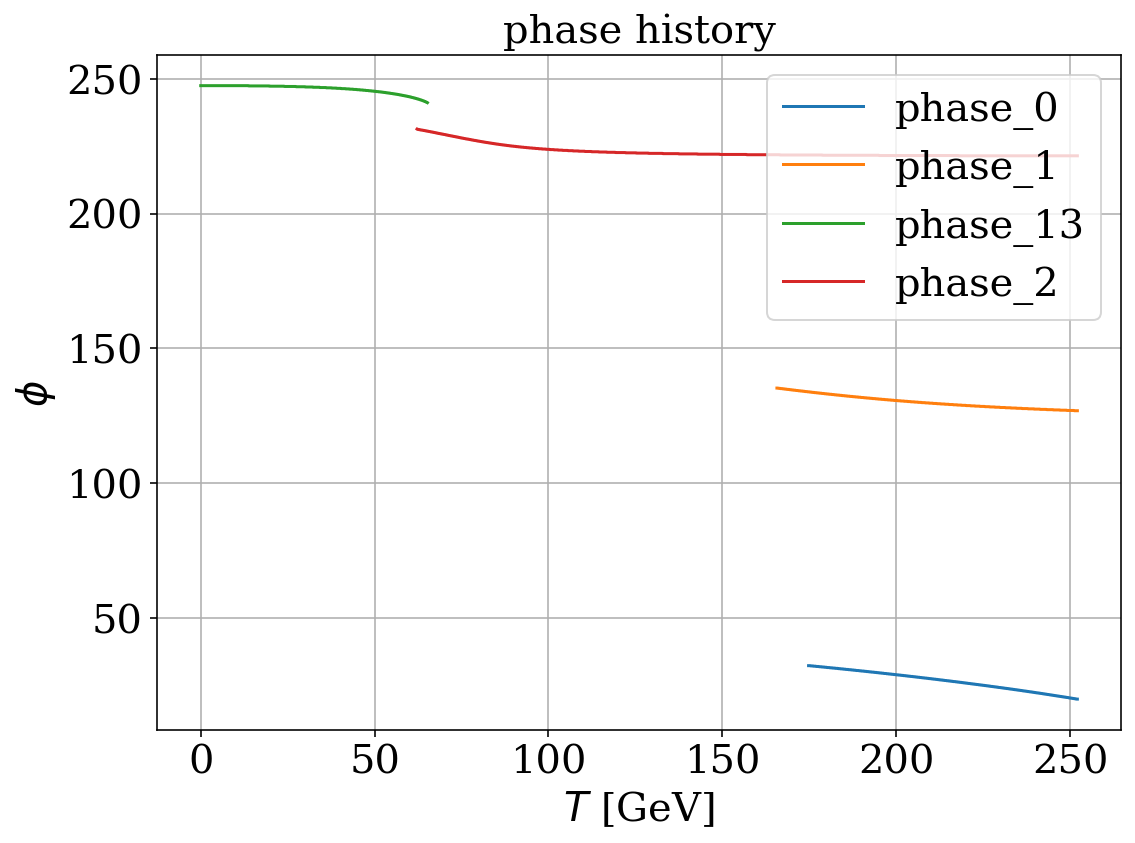

In [20]:
%%time
m.plot3(phases_list)  
plt.savefig('./PLOTS/G_hierachical_phase_hist.pdf', dpi=300)


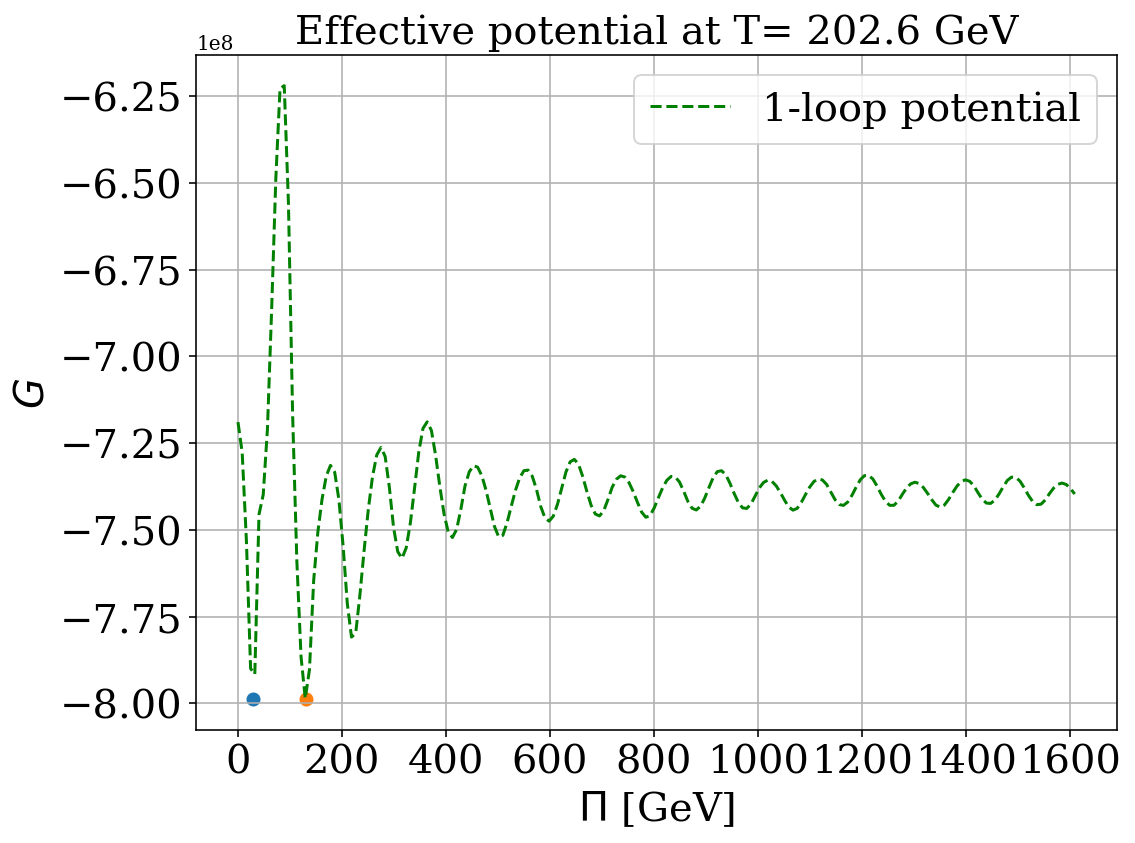

In [21]:
index_trans=0
phase_high=m.phases[m.Tc[index_trans][-1]["high_phase"]]["interp"]
phase_low=m.phases[m.Tc[index_trans][-1]["low_phase"]]["interp"]

Temp=m.Tc[index_trans][-1]["Tc"]
m.plot2(Temp)
plt.scatter(phase_high(Temp),m.Vtot(phase_high(Temp),Temp))
plt.scatter(phase_low(Temp),m.Vtot(phase_low(Temp),Temp))
#plt.xlim(0,m.f)
plt.savefig('./PLOTS/G_hierachical_T1.pdf', dpi=300)
plt.show()

In [ ]:
output=m.findSNR(0)

/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in sqrt
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in sqrt
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in sqrt
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in sqrt
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in sqrt
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in sqrt
/Users/marcoanto

In [ ]:
output

In [20]:
phase_high=m.phases[m.Tc[index_trans][-1]["high_phase"]]
phase_low=m.phases[m.Tc[index_trans][-1]["low_phase"]]
Tmin=m.Tc[index_trans][-1]["Tmin"]
nucleation_list=[]
for temp in np.linspace(Tmin,m.Tc[index_trans][-1]["Tc"]):
    try:
        nuc_output=m.nucleation(phase_high,phase_low,temp)
        if len(nuc_output)!=0:
            nucleation_list.append(nuc_output)
    except:
        continue
    
df_nuc=pd.DataFrame(nucleation_list).dropna()


/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in sqrt
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in sqrt
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in sqrt
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in sqrt
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in sqrt
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in sqrt
/Users/marcoanto

stable not metastable


/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:415: RuntimeWarning: overflow encountered in double_scalars
  r *= 10
/Users/marcoantoniomerchandmedina/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in double_scalars
  beta_r = beta*r


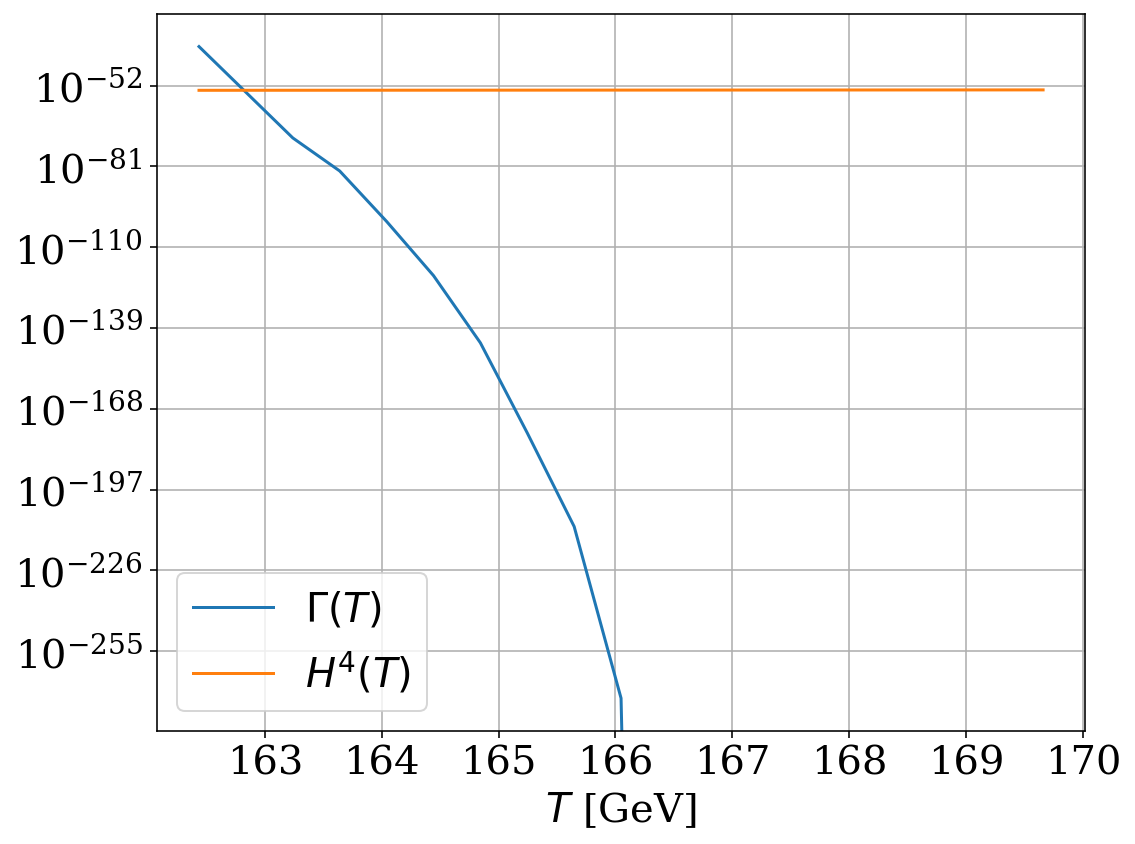

In [21]:
plt.plot(df_nuc["Tn"],df_nuc["Gamma"],label="$\Gamma(T)$")
plt.plot(df_nuc["Tn"],(df_nuc["Hubble1"]+df_nuc["Hubble2"])**2,label="$H^4(T)$")
#plt.plot(df_nuc["Tn"],N_nuc(df_nuc["Tn"])+1)
plt.yscale("log")

plt.xlabel("$T$ [GeV]",size=label_size)
#plt.ylabel("$\Gamma/H^4$",size=label_size)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.grid(True)
plt.legend()
plt.legend(prop={'size': label_size})
#mytitle="Effective potential at T= "+str(T)+" GeV"
#plt.title(mytitle,size=label_size)
plt.tight_layout()
plt.savefig('./PLOTS/Rates_1.pdf', dpi=300)
plt.show()

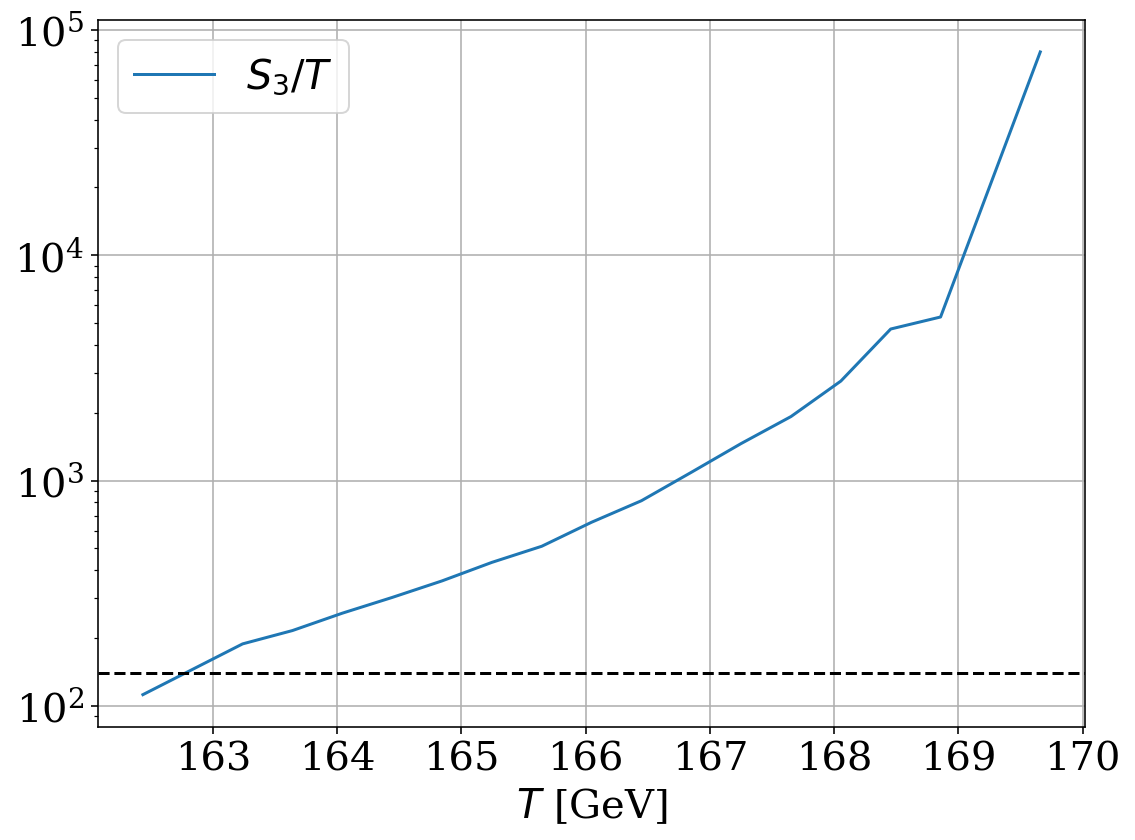

In [22]:
plt.plot(df_nuc["Tn"],df_nuc["S_3"]/df_nuc["Tn"],label="$S_3/T$")
plt.yscale("log")
plt.xlabel("$T$ [GeV]",size=label_size)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.grid(True)
plt.legend(prop={'size': label_size})
plt.axhline(y=140,c="k",linestyle="--",label="140")

plt.tight_layout()
plt.savefig('./PLOTS/Euclidean_action_1.pdf', dpi=300)
plt.show()

In [54]:

N_nuc=interpolate.interp1d(df_nuc["Tn"],df_nuc["Gamma"]/(df_nuc["Hubble1"]+df_nuc["Hubble2"])**2-1)
Tnuc=optimize.root_scalar(N_nuc,bracket=(df_nuc["Tn"].min(),df_nuc["Tn"].max())).root

alpha_inter=interpolate.interp1d(df_nuc["Tn"],df_nuc["alpha"])
vel_inter=interpolate.interp1d(df_nuc["Tn"],df_nuc["vw"])


S_T_inter=interpolate.interp1d(df_nuc["Tn"],df_nuc["S_3"]/df_nuc["Tn"])
beta=Tnuc*misc.derivative(S_T_inter, x0=Tnuc, dx=1e-2, n=1)



163.23934444460664

In [ ]:
Temp,al,beta,vel=Tnuc,alpha_inter(Tnuc),beta,vel_inter(Tnuc)
my_signal=GW_signal(Temp,al,beta,vel)
SNR_signal=SNR_GW(my_signal)

print(SNR_signal)

plt.plot(my_signal[0],my_signal[1])
plt.plot(LISA_sens[::,0],LISA_sens[::,3],color="g")
plt.fill_between(LISA_sens[::,0],LISA_sens[::,3], 1e-2, alpha=0.05,color="g")

#plt.plot(LISA_curve.f,LISA_curve.Omega_lim,alpha=0.05,color="g")
plt.figtext(.4, .72, "LISA", fontsize=label_size)
plt.ylim(1e-28,)
plt.xlim(10**(-5.4),20)

plt.xlabel("$f$ (Hz)",size=label_size)
plt.ylabel("$\\Omega_{GW}$",size=label_size)
plt.xscale("log")
plt.yscale("log")  
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.grid(True)
plt.savefig('./PLOTS/GW.pdf', dpi=300)


In [ ]:

phase_high=m.phases[m.Tc[index_trans][-1]["high_phase"]]["interp"]
phase_low=m.phases[m.Tc[index_trans][-1]["low_phase"]]["interp"]



Temp=m.Trestored-10
m.plot2(Temp)
plt.scatter(phase_high(Temp),m.Vtot(phase_high(Temp),Temp))
plt.scatter(phase_low(Temp),m.Vtot(phase_low(Temp),Temp))
plt.xlim(0,m.f)
plt.savefig('./PLOTS/G_hierachical_T1.pdf', dpi=300)
plt.show()



Temp=m.Tc[index_trans][-1]["Tc"]
m.plot2(Temp)
plt.scatter(phase_high(Temp),m.Vtot(phase_high(Temp),Temp))
plt.scatter(phase_low(Temp),m.Vtot(phase_low(Temp),Temp))
plt.xlim(0,m.f*np.pi/2)
plt.savefig('./PLOTS/G_hierachical_T3.pdf', dpi=300)
plt.show()


Temp=Tnuc
m.plot2(Temp)
plt.scatter(phase_high(Temp),m.Vtot(phase_high(Temp),Temp))
plt.scatter(phase_low(Temp),m.Vtot(phase_low(Temp),Temp))
plt.xlim(0,m.f*np.pi/2)
plt.savefig('./PLOTS/G_hierachical_T4.pdf', dpi=300)
plt.show()

